## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from rdkit import Chem
from mordred import Calculator, descriptors
import seaborn as sns

## Functions

In [2]:
# function to clean raw data from Tecan - assumes readings from 5 full plates stacked vertically
def clean_data(data,normalize=False):
    # makes new copy of data
    df = data.copy(deep=True)
    # blank solutions (acetate) per plate
    blanks = np.zeros(5)
    # siRNA standard solutions per plate
    siRNA = np.zeros(5)
    # stacked data for output
    stack = np.zeros((2,0))
    # iterating over plates
    for i in range(5):
        # subtract blank signal
        blanks[i] = (np.mean([df.loc[i*8,0],df.loc[i*8+6,0],df.loc[i*8,11],df.loc[i*8+6,11]]))
        df.loc[i*8:i*8+7]=df.loc[i*8:i*8+7]-blanks[i]
        
        #normalize to siRNA signal
        if normalize==True:
            siRNA[i] = (np.mean([df.loc[i*8+1,0],df.loc[i*8+1+6,0],df.loc[i*8+1,11],df.loc[i*8+1+6,11]]))
            df.loc[i*8:i*8+7]=df.loc[i*8:i*8+7]/siRNA[i]
        
        # stacking into 2 rows
        for j in range(4):
            stack = np.concatenate((stack,df.loc[i*8+j*2:i*8+j*2+1,1:10]),axis=1)
    
    # transpose stack for 2 columns
    stack = np.transpose(stack)
    
    # returns averaged blank values, stacked data, and siRNA values
    return blanks,stack,siRNA

# calculates the average and absolute value difference for replicate readings
def calc_mean_diff(df_name,col_name):
    df_name[col_name+'_mean']=df_name[[(col_name+'1'),(col_name+'2')]].mean(axis=1)
    df_name[col_name+'_diff']= abs(df_name[col_name+'1'] - df_name[col_name+'2'])
    
# imports data from excel sheet
def import_fl_data(file_name,s1_name,s2_name,s3_name,diff_excl,name1,name2,name3,exp_date):
    all_data = pd.ExcelFile(file_name)
   
    # reading each sheet into a DataFrame 
    raw_1 = pd.read_excel(all_data,s1_name,header=None)
    raw_2 = pd.read_excel(all_data,s2_name,header=None)
    raw_3 = pd.read_excel(all_data,s3_name,header=None)
    
    # importing list of drugs tested
    drug_list = pd.read_excel(all_data,'drug_list')
    
    # cleaning up data from raw readings of plates
    [b1,s1,r1] = clean_data(raw_1,False)
    [b2,s2,r2] = clean_data(raw_2,True)
    [b3,s3,r3] = clean_data(raw_3,True)
    
    # combining cleaned data from numpy arrays into DataFrames
    df_1 = pd.DataFrame(s1)
    df_1.columns = [name1+'1',name1+'2']
    df_2 = pd.DataFrame(s2)
    df_2.columns = [name2+'1',name2+'2']
    df_3 = pd.DataFrame(s3)
    df_3.columns = [name3+'1',name3+'2']
    
    # Concatenation of DataFrames for each set of readings into one DataFrame
    data = pd.concat([drug_list,df_1[0:192],df_2[0:192],df_3[0:192]],axis=1)
    data = data.set_index(['Cat No','Drug']).dropna()
    
    # Adding additional columns that calcualte the average and difference of replicate readings
    calc_mean_diff(data,name1)
    calc_mean_diff(data,name2)
    calc_mean_diff(data,name3)
    
    # Setting values as NaN for data where the variability is large (difference > 0.2)
    if diff_excl:
        data[data['RG_diff']>0.2] = data[data['RG_diff']>0.2].assign(RG_mean=np.NaN)
    
    # Adding an additional column index with the date of the experiment
    data1 = pd.concat([data],keys=[exp_date],axis=1)
    
    return data1

# function to make DataFrame in correct format dot plots of fluorescence data
def stack_RG(df_in,col_keep):
    
    dataRG = df_in[col_keep].copy(deep=True)
    dataRG['Type'] = 'RG'
    dataRG = dataRG.rename(columns={dataRG.columns[1]: 'Signal'})

    dataRGT = df_in[col_keep].copy(deep=True)
    dataRGT['Type'] = 'RGT'
    dataRGT = dataRGT.rename(columns={dataRG.columns[2]: 'Signal'})
    
    dataRGTH = df_in[col_keep].copy(deep=True)
    dataRGTH['Type'] = 'RGTH'
    dataRGTH = dataRGTH.rename(columns={dataRG.columns[3]: 'Signal'})
    
    return pd.concat([dataRG,dataRGT,dataRGTH],ignore_index = True)

## Data import

In [3]:
# importing data from 2022_10_24
data1 = import_fl_data('Data_files/2022_10_24_screen_results.xlsx',
                       '2022_10_24_noRG','2022_10_24_RG','2022_10_24_RGT',
                       # flag to remove high variability data
                       True,
                      'noRG','RG','RGT','2022_10_24')

# importing data from 2022_11_11
data2 = import_fl_data('Data_files/2022_11_11_screen_results.xlsx',
                       '2022_11_11_noRG','2022_11_11_RG','2022_11_11_RGTH',
                        # flag to remove high variability data
                        True,
                        'noRG','RG','RGTH','2022_11_11')

# combining data from all dates into one DataFrame
data_all = pd.concat([data1,data2],axis=1)

# calculating global averages of readings (excludes values that are NaN)
data_group = data_all.groupby(axis=1,level=1).mean()
data_group = data_group[data_group.columns[data_group.columns.str.contains('mean')]]
data_group = pd.concat([data_group],keys=['All'],axis=1)

# combines global averages into the DataFrame
data_all = pd.concat([data_all,data_group],axis=1)
data_all

# reads drug properties from MedChemExpress list 
MCE_drugs = pd.read_csv('Data_files/MCE_all_drugs_1.csv')
MCE_drugs = MCE_drugs.set_index(['Catalog Number'])
# add data from MCE_drugs into DataFrame of experimental data
df_all = pd.concat([MCE_drugs,data_all.droplevel(level=1)], axis=1)
df_all

,level_0,index,drugbank_id,cas,name,type,groups,categories,MW,logP,...,"(2022_11_11, noRG_mean)","(2022_11_11, noRG_diff)","(2022_11_11, RG_mean)","(2022_11_11, RG_diff)","(2022_11_11, RGTH_mean)","(2022_11_11, RGTH_diff)","(All, RGTH_mean)","(All, RGT_mean)","(All, RG_mean)","(All, noRG_mean)"
HY-N0480,102,195,DB00206,50-55-5,Reserpine,small molecule,"['approved', 'investigational']","['Adrenergic Agents', 'Adrenergic Uptake Inhib...",608.6787,4.05,...,0.25,2.0,0.639740,0.009803,0.511627,0.008246,0.511627,0.793527,0.707069,-0.125
HY-17506,103,196,DB00207,83905-01-5,Azithromycin,small molecule,['approved'],"['Anti-Bacterial Agents', 'Anti-Infective Agen...",748.9845,3.03,...,-0.25,2.0,1.062971,0.028482,1.128922,0.015419,1.128922,1.194510,1.054428,-3.000
HY-B0153A,104,197,DB00208,55142-85-3,Ticlopidine,small molecule,['approved'],"['Antiplatelet agents', 'Blood and Blood Formi...",263.7860,4.25,...,0.25,1.0,1.172789,0.033329,0.880497,0.022353,0.880497,0.993832,1.057829,-0.750
HY-B1287,111,204,DB00215,59729-33-8,Citalopram,small molecule,['approved'],"['Amines', 'Antidepressive Agents', 'Antidepre...",324.3919,3.58,...,-0.75,1.0,1.122414,0.003619,0.931889,0.013375,0.931889,0.961440,1.015802,-1.500
HY-A0010,112,205,DB00216,143322-58-1,Eletriptan,small molecule,"['approved', 'investigational']","['Agents that produce hypertension', 'Amines',...",382.5190,3.84,...,1.75,2.0,0.770493,0.000888,0.651648,0.107481,0.651648,0.644365,0.745876,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HY-18208,775,868,DB00886,167305-00-2,Omapatrilat,small molecule,['investigational'],['Agents Acting on the Renin-Angiotensin Syste...,408.5300,2.15,...,-0.75,1.0,1.094549,0.011558,0.747296,0.032552,0.747296,1.020385,1.091463,-2.500
HY-13648,8449,9664,DB11647,15866-90-7,Incyclinide,small molecule,['investigational'],['Naphthacenes'],371.3450,-0.38,...,4.25,1.0,1.019855,0.014474,0.787147,0.018139,0.787147,0.736044,0.890418,3.500
HY-15097,2138,2247,DB02375,529-44-2,Myricetin,small molecule,['experimental'],"['Benzopyrans', 'Chromones', 'Heterocyclic Com...",318.2351,1.66,...,0.75,1.0,0.011055,0.000572,0.263494,0.001106,0.263494,0.312141,0.010876,0.375
HY-B0960,7929,8352,DB09355,127-71-9,Sulfabenzamide,small molecule,['approved'],"['Amides', 'Sulfones', 'Sulfur Compounds']",276.3110,1.69,...,3.75,8.0,1.050629,0.010044,0.932852,0.009390,0.932852,0.963051,1.012424,1.250


## Filtering dataset

In [4]:
filt_high_pre_RG = True
filt_low_post_disr = True
filt_decr_Trit = True

# remove data with high pre-RG fluorescence
if filt_high_pre_RG:
    Q1 = df_all['All','noRG_mean'].quantile(0.25)
    Q3 = df_all['All','noRG_mean'].quantile(0.75)
    IQR = Q3-Q1
    data_filt = df_all[df_all['All','noRG_mean'] < Q3 + 3*IQR]

# remove data with low post-disruption fluorescence
if filt_low_post_disr:
    TH_thresh = 0.75
    T_thresh = 0.75
    
    data_filt = data_filt[(data_filt['All','RGTH_mean']>TH_thresh) | (data_filt['All','RGT_mean']>T_thresh)]

# remove data with >20% decrease in relative fluorescence after addition of Triton
if filt_decr_Trit:
    data_filt = data_filt[(data_filt['All','RGT_mean']-data_filt['All','RG_mean'])/data_filt['All','RG_mean']>-0.2]

data_filt

,level_0,index,drugbank_id,cas,name,type,groups,categories,MW,logP,...,"(2022_11_11, noRG_mean)","(2022_11_11, noRG_diff)","(2022_11_11, RG_mean)","(2022_11_11, RG_diff)","(2022_11_11, RGTH_mean)","(2022_11_11, RGTH_diff)","(All, RGTH_mean)","(All, RGT_mean)","(All, RG_mean)","(All, noRG_mean)"
HY-N0480,102,195,DB00206,50-55-5,Reserpine,small molecule,"['approved', 'investigational']","['Adrenergic Agents', 'Adrenergic Uptake Inhib...",608.6787,4.05,...,0.25,2.0,0.639740,0.009803,0.511627,0.008246,0.511627,0.793527,0.707069,-0.125
HY-17506,103,196,DB00207,83905-01-5,Azithromycin,small molecule,['approved'],"['Anti-Bacterial Agents', 'Anti-Infective Agen...",748.9845,3.03,...,-0.25,2.0,1.062971,0.028482,1.128922,0.015419,1.128922,1.194510,1.054428,-3.000
HY-B0153A,104,197,DB00208,55142-85-3,Ticlopidine,small molecule,['approved'],"['Antiplatelet agents', 'Blood and Blood Formi...",263.7860,4.25,...,0.25,1.0,1.172789,0.033329,0.880497,0.022353,0.880497,0.993832,1.057829,-0.750
HY-B1287,111,204,DB00215,59729-33-8,Citalopram,small molecule,['approved'],"['Amines', 'Antidepressive Agents', 'Antidepre...",324.3919,3.58,...,-0.75,1.0,1.122414,0.003619,0.931889,0.013375,0.931889,0.961440,1.015802,-1.500
HY-15287,116,209,DB00220,159989-64-7,Nelfinavir,small molecule,['approved'],"['Anti-HIV Agents', 'Anti-Infective Agents', '...",567.7820,4.61,...,0.00,2.0,1.197751,0.050633,1.110937,0.007588,1.110937,1.037179,1.156914,-0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HY-B1684,11438,13676,DB15779,78266-06-5,Mebrofenin,small molecule,"['approved', 'experimental']",[],387.2300,-0.39,...,-0.25,1.0,1.148326,0.034845,0.865349,0.080348,0.865349,1.048516,1.127932,-0.625
HY-18208,775,868,DB00886,167305-00-2,Omapatrilat,small molecule,['investigational'],['Agents Acting on the Renin-Angiotensin Syste...,408.5300,2.15,...,-0.75,1.0,1.094549,0.011558,0.747296,0.032552,0.747296,1.020385,1.091463,-2.500
HY-13648,8449,9664,DB11647,15866-90-7,Incyclinide,small molecule,['investigational'],['Naphthacenes'],371.3450,-0.38,...,4.25,1.0,1.019855,0.014474,0.787147,0.018139,0.787147,0.736044,0.890418,3.500
HY-B0960,7929,8352,DB09355,127-71-9,Sulfabenzamide,small molecule,['approved'],"['Amides', 'Sulfones', 'Sulfur Compounds']",276.3110,1.69,...,3.75,8.0,1.050629,0.010044,0.932852,0.009390,0.932852,0.963051,1.012424,1.250


## Output

In [6]:
# output RiboGreen data with molecule names and structures for generation of molecular descriptors for filtered data
data_out = data_filt[['cas','name','SMILES','MW','logP','cb_pKa','Group']]
data_out['RG'] = data_filt['All','RG_mean']
data_out.to_csv('Data_files/data_for_descriptor_generation.csv')

# output RiboGreen data with molecule names and structures for generation of molecular descriptors for all data
data_out_2 = df_all[['cas','name','SMILES','MW','logP','cb_pKa','Group']]
data_out_2['RG'] = df_all['All','RG_mean']
data_out_2.to_csv('Data_files/all_data_from_screening_set_1.csv')

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Using Online chemical database (ochem.eu) for molecular descriptor generation

##### Uploaded csv data to ochem.eu
##### Calculated descriptors
##### Standardized by CDK (standardization, neutralize, remove salts, clean structure)
##### Selected alvaDesc v.2.0.16 (5666/3D)
##### Optimise with Corina

#### Generated descriptors from filtered DrugBank drugs using same settings


### Plotting filtered data

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


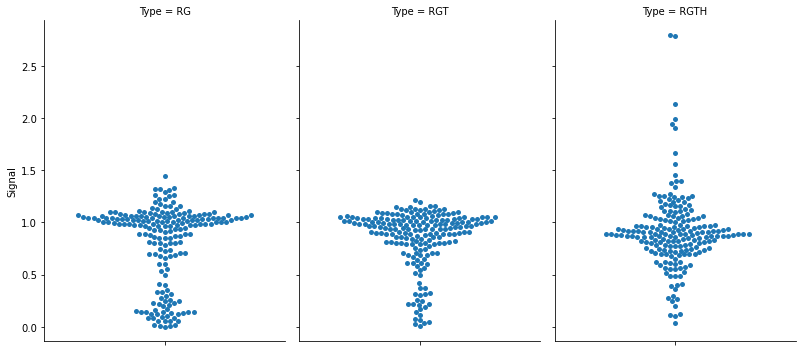

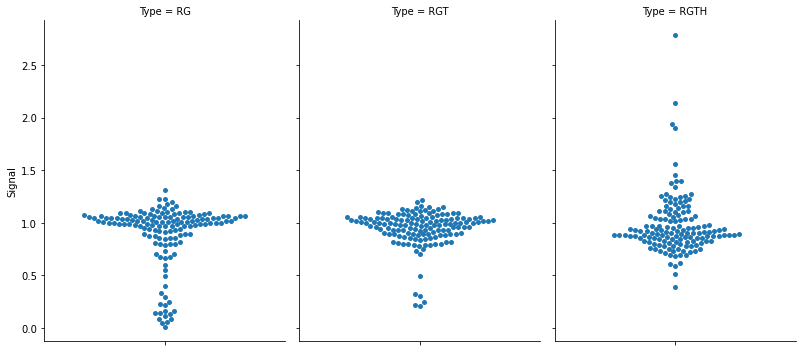

In [6]:
# Plotting pre-filtered data
data2=stack_RG(df_all,['name',('All','RG_mean'),('All','RGT_mean'),('All','RGTH_mean'),'Group'] )
sns.catplot(kind="swarm",y="Signal",data=data2,col="Type",aspect=0.75)

# Plotting post-filtered data
data2=stack_RG(data_filt,['name',('All','RG_mean'),('All','RGT_mean'),('All','RGTH_mean'),'Group'])
sns.catplot(kind="swarm",y="Signal",data=data2,col="Type",aspect=0.75)